In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import os
import shutil
from sklearn.preprocessing import StandardScaler,RobustScaler,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer,IterativeImputer
import miceforest as mic
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from Sensor.utils.main_utils import load_numpy_array,load_object
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Global variables
data_path='D:\DataScience\Projects\SensorProject\End-To-End-ML-Project\Artifact\ingested//training_data.csv'

# Problem Statement:-
The Air Pressure System (APS) in trucks is a fundamental component that ensures the safe and efficient operation of the vehicle, primarily focusing on the braking system but also extending its utility to other functions such as suspension and accessory operations.

At the heart of the APS is the air compressor, which is driven by the truck’s engine. The compressor takes in air from the atmosphere, compresses it, and sends it to air reservoirs for storage. These air reservoirs act as holding tanks, ensuring a steady supply of compressed air is available when needed.

The primary use of the APS is within the air brake system, which is essential for the safe operation of heavy trucks. When the driver presses the brake pedal, a foot valve regulates the flow of compressed air from the reservoirs to the brake chambers. This pressurized air then pushes a diaphragm or piston within the brake chambers, converting the air pressure into mechanical force that applies the brakes by moving the brake shoes against the brake drums or discs. This system ensures a powerful and reliable braking force, which is crucial for stopping heavy loads effectively.

In addition to braking, the APS also powers the truck’s air suspension system. This system uses compressed air to provide a smoother ride by adjusting the vehicle's height and absorbing shocks from the road. The air suspension not only enhances driver comfort but also protects the cargo from damage due to road vibration.

Safety is a critical aspect of the APS. Modern trucks are equipped with a dual air brake system that divides the braking system into two separate circuits. This redundancy ensures that if one circuit fails, the other can still provide braking power. Regular maintenance of the APS is essential to ensure its reliability and efficiency. This includes routine inspections for leaks, checking air pressure levels, and verifying the operation of all valves and safety feature

**We have a dataset where, we have to classify if the failure was because of the APS system or not. The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions** 

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty truck, which may cause a breakdown. 
- `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`
- `Cost 1 = 10 and Cost 2 = 500`

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to **reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.**

# Dataset Information:-
**class column:-** Represents if the failure was because of the APS system or not. pos indicates that the failure was because of the APS system. neg indicates that the failure was not.

**We have no information regarding the other columns. We might try to form some intuitive from their names and by researching which sensors are used in APS systems and what kind of data they collect.**


# Quick Data Exploration:-

In [9]:
df=pd.read_csv(data_path)
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,41264,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,432424.0,224322.0,524648.0,429094.0,154894.0,67774.0,95080.0,4134.0,0.0,0.0
1,neg,1504,0.0,6.000000e+00,6.0,0.0,0.0,0.0,0.0,0.0,...,7300.0,2582.0,3908.0,5842.0,13712.0,30026.0,134.0,0.0,0.0,0.0
2,neg,39126,0.0,2.130706e+09,206.0,58.0,82.0,0.0,0.0,0.0,...,270432.0,116362.0,342716.0,154848.0,223658.0,604250.0,9638.0,0.0,0.0,0.0
3,neg,36458,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,341548.0,190988.0,626708.0,391986.0,6182.0,624.0,118.0,0.0,0.0,0.0
4,neg,26,0.0,1.600000e+01,6.0,0.0,0.0,0.0,0.0,0.0,...,482.0,78.0,76.0,50.0,104.0,88.0,0.0,0.0,0.0,0.0


In [10]:
df.tail()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
28945,neg,40374,NaN,4.240000e+02,390.0,0.0,0.0,0.0,0.0,0.0,...,533356.0,242706.0,422882.0,252938.0,143670.0,87964.0,163742.0,21684.0,0.0,0.0
28946,neg,14,2.0,4.800000e+01,30.0,0.0,0.0,0.0,0.0,0.0,...,228.0,36.0,68.0,18.0,4.0,0.0,0.0,0.0,0.0,0.0
28947,neg,192,0.0,2.130706e+09,52.0,0.0,0.0,0.0,0.0,0.0,...,1484.0,656.0,1616.0,1856.0,1160.0,1208.0,0.0,0.0,0.0,0.0
28948,neg,102022,NaN,2.130706e+09,584.0,0.0,0.0,0.0,0.0,0.0,...,960750.0,515708.0,1159870.0,1239992.0,653868.0,134726.0,35670.0,6.0,0.0,0.0
28949,neg,206224,0.0,2.106000e+03,NaN,0.0,0.0,0.0,0.0,5196.0,...,718786.0,289700.0,508768.0,407838.0,504136.0,5754118.0,280260.0,170.0,0.0,0.0


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28950 entries, 0 to 28949
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 37.8+ MB
None


In [12]:
df.describe(include='all')

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,28950,2.895000e+04,6591.000000,2.724600e+04,2.158200e+04,27687.000000,27687.000000,2.864900e+04,2.864900e+04,2.864900e+04,...,2.864800e+04,2.864800e+04,2.864800e+04,2.864800e+04,2.864800e+04,2.864800e+04,2.864800e+04,2.864800e+04,27573.000000,27574.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,neg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,28146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.599028e+04,0.694584,3.542579e+08,3.982014e+05,7.251996,11.353054,2.207984e+02,1.572640e+03,1.299262e+04,...,4.831604e+05,2.281800e+05,4.824096e+05,4.396592e+05,3.702650e+05,3.724048e+05,1.487664e+05,9.098536e+03,0.080949,0.213172
std,NaN,1.630945e+05,2.903407,7.933115e+08,5.843310e+07,197.983864,234.607418,2.063260e+04,4.454742e+04,1.871635e+05,...,1.224788e+06,5.798737e+05,1.232159e+06,1.324555e+06,1.229136e+06,1.706104e+06,5.097724e+05,5.474264e+04,3.820521,9.404337
min,NaN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,NaN,8.680000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.997000e+03,1.200000e+03,2.747500e+03,3.739500e+03,5.520000e+02,1.160000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,NaN,3.112900e+04,0.000000,1.510000e+02,1.280000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.408290e+05,1.153490e+05,2.293450e+05,1.961020e+05,9.846700e+04,4.304300e+04,4.379000e+03,0.000000e+00,0.000000,0.000000
75%,NaN,5.041900e+04,0.000000,9.500000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.510645e+05,2.239245e+05,4.774055e+05,4.136305e+05,2.803780e+05,1.708120e+05,1.445180e+05,2.098500e+03,0.000000,0.000000


In [13]:
df.dtypes

class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

In [14]:
df.shape

(28950, 171)

In [15]:
df.isnull().sum()

class         0
aa_000        0
ab_000    22359
ac_000     1704
ad_000     7368
          ...  
ee_007      302
ee_008      302
ee_009      302
ef_000     1377
eg_000     1376
Length: 171, dtype: int64

**The data types of features are correct. We have alot of missing values.**

# Data Assesment
**Let's try to find if there are any problems with with our data.**

Upon going to through data manually, we can encounter following problems:-
1. ALot of columns have 90% of their entries as 0. (we dont know if it is a validation issue or completion issue or accuracy issue )
2. Alot of columns have more then 90% of their values as NAN. (completion issue)
3. ac_000 column has few entries like 2130706432 repeated at different places. This can be seen at multiple places. (accuracy issue)
4. cd_000 has just 1 entry for all rows. (validation issue)
5. There is no tidy or messy data.
6. There are zero entries for almost all rows and we don't know if 0 is an legit entry or an encoded missing value.

In [16]:
# Analyze the column names
columns=df.columns.to_list()[1:]
first_letters=set([col[0] for col in columns])
for letter in first_letters:
    cols=[col for col in columns if col.startswith(letter)]
    dic={}
    for col in cols:
        if col[0:2]in dic:
            dic[col[0:2]]+=1
        else:
            dic[col[0:2]]=1
    print(dic)

{'ea': 1, 'eb': 1, 'ec': 1, 'ed': 1, 'ee': 10, 'ef': 1, 'eg': 1}
{'aa': 1, 'ab': 1, 'ac': 1, 'ad': 1, 'ae': 1, 'af': 1, 'ag': 10, 'ah': 1, 'ai': 1, 'aj': 1, 'ak': 1, 'al': 1, 'am': 1, 'an': 1, 'ao': 1, 'ap': 1, 'aq': 1, 'ar': 1, 'as': 1, 'at': 1, 'au': 1, 'av': 1, 'ax': 1, 'ay': 10, 'az': 10}
{'da': 1, 'db': 1, 'dc': 1, 'dd': 1, 'de': 1, 'df': 1, 'dg': 1, 'dh': 1, 'di': 1, 'dj': 1, 'dk': 1, 'dl': 1, 'dm': 1, 'dn': 1, 'do': 1, 'dp': 1, 'dq': 1, 'dr': 1, 'ds': 1, 'dt': 1, 'du': 1, 'dv': 1, 'dx': 1, 'dy': 1, 'dz': 1}
{'ba': 10, 'bb': 1, 'bc': 1, 'bd': 1, 'be': 1, 'bf': 1, 'bg': 1, 'bh': 1, 'bi': 1, 'bj': 1, 'bk': 1, 'bl': 1, 'bm': 1, 'bn': 1, 'bo': 1, 'bp': 1, 'bq': 1, 'br': 1, 'bs': 1, 'bt': 1, 'bu': 1, 'bv': 1, 'bx': 1, 'by': 1, 'bz': 1}
{'ca': 1, 'cb': 1, 'cc': 1, 'cd': 1, 'ce': 1, 'cf': 1, 'cg': 1, 'ch': 1, 'ci': 1, 'cj': 1, 'ck': 1, 'cl': 1, 'cm': 1, 'cn': 10, 'co': 1, 'cp': 1, 'cq': 1, 'cr': 1, 'cs': 10, 'ct': 1, 'cu': 1, 'cv': 1, 'cx': 1, 'cy': 1, 'cz': 1}


**It might be the case that a,b,c,d and e which are the first letters of the columns might represent different components and 2nd letter might denote different sensors in that component and the digits might correspond to the sensor number.**


In [17]:
# Create a empty set which will be used to store features which we will be dropping.
drop_cols=set()

In [18]:
# print columns which have more then 80% of their values as NAN.
for col in columns:
    if (len(df[df[col].isna()])/len(df))>0.70:
        print(f"Column {col} has {len(df[df[col].isna()])/len(df)*100}% entries which are NAN")
        drop_cols.add(col)

Column ab_000 has 77.23316062176166% entries which are NAN
Column bn_000 has 72.67357512953367% entries which are NAN
Column bo_000 has 76.50086355785838% entries which are NAN
Column bp_000 has 78.80483592400691% entries which are NAN
Column bq_000 has 80.51122625215889% entries which are NAN
Column br_000 has 81.47150259067357% entries which are NAN
Column cr_000 has 77.23316062176166% entries which are NAN


In [19]:
# Print columns which have 0 for more than 90% rows.
for col in columns:
    if (len(df[df[col]==0])/len(df))>0.90:
        print(f"Column {col} has entry 0 {(len(df[df[col]==0])/len(df))*100}% times.")
        drop_cols.add(col)

Column ae_000 has entry 0 92.56994818652849% times.
Column af_000 has entry 0 92.44905008635578% times.
Column ag_000 has entry 0 98.55267702936096% times.
Column ag_001 has entry 0 97.39896373056995% times.
Column ag_002 has entry 0 93.29879101899827% times.
Column ak_000 has entry 0 91.65803108808291% times.
Column ar_000 has entry 0 91.16753022452504% times.
Column as_000 has entry 0 98.95682210708118% times.
Column au_000 has entry 0 98.87737478411054% times.
Column ay_000 has entry 0 97.86528497409327% times.
Column ay_001 has entry 0 97.00518134715026% times.
Column ay_002 has entry 0 96.94991364421416% times.
Column ay_003 has entry 0 96.79447322970638% times.
Column ay_004 has entry 0 95.22279792746114% times.
Column ay_009 has entry 0 97.86528497409327% times.
Column az_008 has entry 0 90.38687392055267% times.
Column az_009 has entry 0 95.73747841105354% times.
Column cn_000 has entry 0 95.17443868739205% times.
Column cs_009 has entry 0 94.17962003454231% times.
Column df_00

In [20]:
df['ae_000'].value_counts().head(1).values

array([26799])

In [21]:
# Print columns which have just one entry for more than 90% rows.
for col in columns:
    if (df[col].value_counts().head(1).values[0]/len(df))>0.90:
        print(f"Column {col} has entry {df[col].value_counts().head(1).index[0]} {df[col].value_counts().head(1).values[0]/len(df)*100} % times")
        drop_cols.add(col)

Column ae_000 has entry 0.0 92.56994818652849 % times
Column af_000 has entry 0.0 92.44905008635578 % times
Column ag_000 has entry 0.0 98.55267702936096 % times
Column ag_001 has entry 0.0 97.39896373056995 % times
Column ag_002 has entry 0.0 93.29879101899827 % times
Column ak_000 has entry 0.0 91.65803108808291 % times
Column ar_000 has entry 0.0 91.16753022452504 % times
Column as_000 has entry 0.0 98.95682210708118 % times
Column au_000 has entry 0.0 98.87737478411054 % times
Column ay_000 has entry 0.0 97.86528497409327 % times
Column ay_001 has entry 0.0 97.00518134715026 % times
Column ay_002 has entry 0.0 96.94991364421416 % times
Column ay_003 has entry 0.0 96.79447322970638 % times
Column ay_004 has entry 0.0 95.22279792746114 % times
Column ay_009 has entry 0.0 97.86528497409327 % times
Column az_008 has entry 0.0 90.38687392055267 % times
Column az_009 has entry 0.0 95.73747841105354 % times
Column cd_000 has entry 1209600.0 98.93264248704664 % times
Column cn_000 has entr

In [22]:
# Check if there are any negative values in the dataset.
for col in columns:
    if len(df[df[col]<0]):
        print(col)
        drop_cols.add(col)

In [23]:
print(drop_cols)

{'bo_000', 'dz_000', 'ae_000', 'ay_002', 'az_009', 'dg_000', 'ay_009', 'as_000', 'ef_000', 'ay_004', 'cr_000', 'cd_000', 'eg_000', 'af_000', 'ay_000', 'ay_003', 'dl_000', 'ea_000', 'ay_001', 'dk_000', 'ak_000', 'ar_000', 'df_000', 'az_008', 'dj_000', 'au_000', 'cn_000', 'dm_000', 'ab_000', 'ag_000', 'bn_000', 'br_000', 'cs_009', 'ag_001', 'bq_000', 'bp_000', 'ag_002'}


In [24]:
# Check for duplicated rows
df.duplicated().sum()

np.int64(0)

In [25]:
print(f"Column ac_000 has entries like 2130706432 for {np.round(len(df[df['ac_000']>20000])/len(df)*100,2)}% times")

Column ac_000 has entries like 2130706432 for 15.74% times


<Axes: xlabel='ac_000', ylabel='Density'>

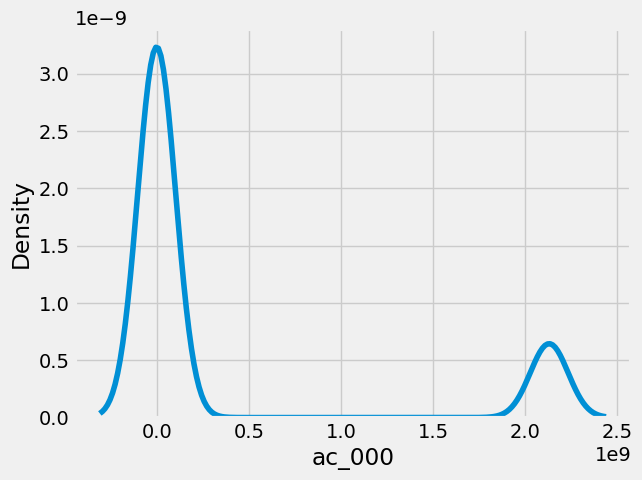

In [26]:
# Let's check the histogram of ac_000
sns.kdeplot(df['ac_000'])

In [27]:
print([col for col in df.columns if col not in drop_cols])

['class', 'aa_000', 'ac_000', 'ad_000', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'at_000', 'av_000', 'ax_000', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000', 'cl_000', 'cm_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'co_000', 'cp_000', 'cq_000', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cs_006', 'cs_007', 'cs_008', 'ct_000', 'cu_000', 'cv_000', 'c

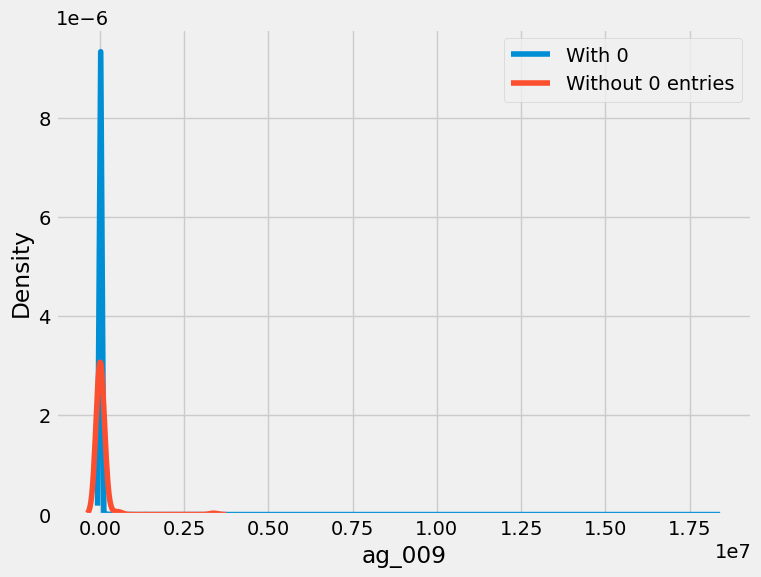

In [28]:
# Let's check if the histograms of columns to find out if 0 is an valid entry
fig,ax=plt.subplots(figsize=(8,6))
sns.kdeplot(df['ag_009'],label='With 0')
sns.kdeplot(df[df['ag_000']!=0]['ag_000'],label='Without 0 entries')
plt.legend()

In [29]:
# Let's try to find correlation between 0 entries in one col with missing entries in another.
new_df=df.drop(drop_cols,axis=1)
zero_indicators = new_df.applymap(lambda x: 1 if x == 0 else 0)
zero_indicators.columns = [f'{col}_zero' for col in new_df.columns]

# Indicator columns for missing entries
missing_indicators = new_df.isnull().astype(int)
missing_indicators.columns = [f'{col}_missing' for col in new_df.columns]
indicators = pd.concat([zero_indicators, missing_indicators], axis=1)
correlation_matrix = indicators.corr()
zero_missing_correlations = correlation_matrix.loc[zero_indicators.columns, missing_indicators.columns]
high_correlation_threshold = 0.6

# Find high correlations
high_correlations = zero_missing_correlations > high_correlation_threshold
high_correlated_pairs = high_correlations[high_correlations].stack().index.tolist()
print("High correlations between zero values and missing values:")
for zero_col, missing_col in high_correlated_pairs:
    print(f'{zero_col} and {missing_col} with correlation {zero_missing_correlations.loc[zero_col, missing_col]}')

High correlations between zero values and missing values:
ag_008_zero and bk_000_missing with correlation 0.7272079235442963
ag_008_zero and bl_000_missing with correlation 0.6381889758553242
av_000_zero and ad_000_missing with correlation 0.6111265816971249
av_000_zero and cf_000_missing with correlation 0.6111265816971249
av_000_zero and cg_000_missing with correlation 0.6111265816971249
av_000_zero and ch_000_missing with correlation 0.6111265816971249
av_000_zero and co_000_missing with correlation 0.6111265816971249
av_000_zero and ct_000_missing with correlation 0.6444969053511002
av_000_zero and cu_000_missing with correlation 0.6444969053511002
av_000_zero and cv_000_missing with correlation 0.6444969053511002
av_000_zero and cx_000_missing with correlation 0.6444969053511002
av_000_zero and cy_000_missing with correlation 0.6444969053511002
av_000_zero and cz_000_missing with correlation 0.6444969053511002
av_000_zero and da_000_missing with correlation 0.6444969053511002
av_0

In [30]:
# Extract the columns
cols=set([col[0][:-5] for col in high_correlated_pairs])
print(cols)

{'ax_000', 'ag_008', 'av_000', 'cn_009', 'cp_000', 'bf_000', 'ce_000', 'ee_008'}


**Based on above analysis we conflicting results:- The histograms of variables when 0 is included and when 0 is excluded overlap significantly and we might say that 0's are infact legitimate values of vairables. After doing correlation analysis of the 0 values with missing values in another columns we might say that the above displayed columns have missing values encoded as 0 and for this variables 0 is not an legitimate value. During Model Building we can experiment with both this approaches, by treating them as legitimate values and by treating them as encoded missing values.**

# Data Cleaning
1. We will drop the columns which we have added to the set drop_cols
2. The column ac_000 has entries like 2130706432 for multiple rows, Multiple other variables have similar distributions, so let's treat this as normal.
3. We will experiment with 2 settings mentioned above.
4. We will handle missing values and outliers later on.

In [31]:
# We can drop the drop_cols
df=df.drop(list(drop_cols),axis=1)

# Create a copy of dataframe
new_df=df.copy()

# Encode 0's values with missing values for the above extracted columns
new_df.loc[:,list(cols)]=new_df[list(cols)].replace({0:np.nan})

# Let's drop columns which have lot of missing values
new_drop_cols=set()
for col in new_df.columns:
    if df[col].isna().sum()/len(df)>0.80:
        new_drop_cols.add(col)
print(new_drop_cols)

new_df=new_df.drop(list(new_drop_cols),axis=1)

set()



**Conclusions from data assesment and cleaning:-**
1. Features cannot be interpreted. 
2. Handled variables which have a single value, missing values significantly
3. Handled 0 which are encoded missing values.

# Exploratory Data Analysis:-

**Usually in EDA, we try to analyze the features and extract patterns from it. Since for this dataset we cannot interpret the features we have to rely on some of the advanced techniques like PCA, cluster analysis etc.**


([<matplotlib.patches.Wedge at 0x1ca78d54cd0>,
 [Text(-1.0958159149424949, 0.09585134614987603, 'neg'),
  Text(1.0958159233220817, -0.095851250350602, 'pos')],
 [Text(-0.5977177717868153, 0.05228255244538692, '97.2%'),
  Text(0.597717776357499, -0.05228250019123745, '2.8%')])

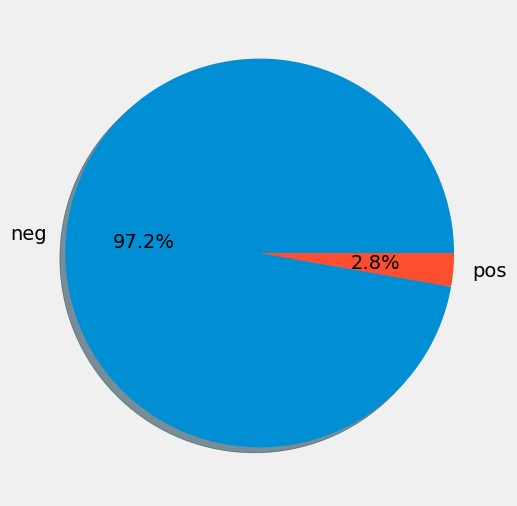

In [32]:
fig,ax=plt.subplots(figsize=(8,6))
ax.pie(df['class'].value_counts().values,labels=df['class'].value_counts().index,shadow=True,autopct='%1.1f%%')

**There is class imbalance in the dataset. We have to take care of this.**

## Choosing which scaling technique to use
**Since our data is highly right skewed, going forward to apply cluster analysis, pca, or even during model development we have to first scale our data, so let's decide which scaling technique to use and how to handle the outliers in our data.**

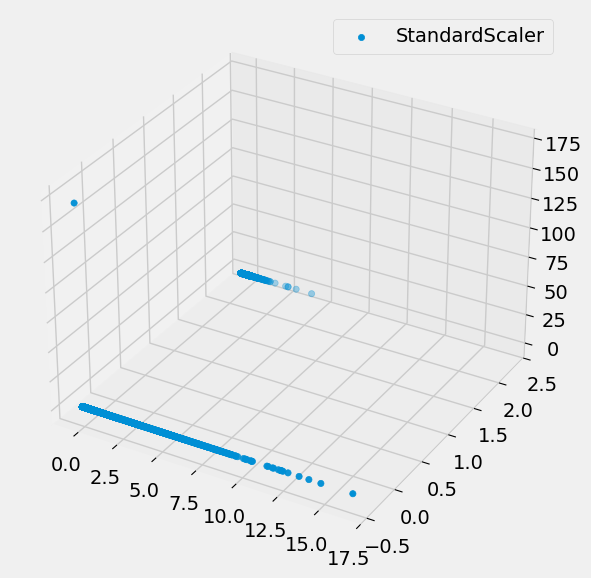

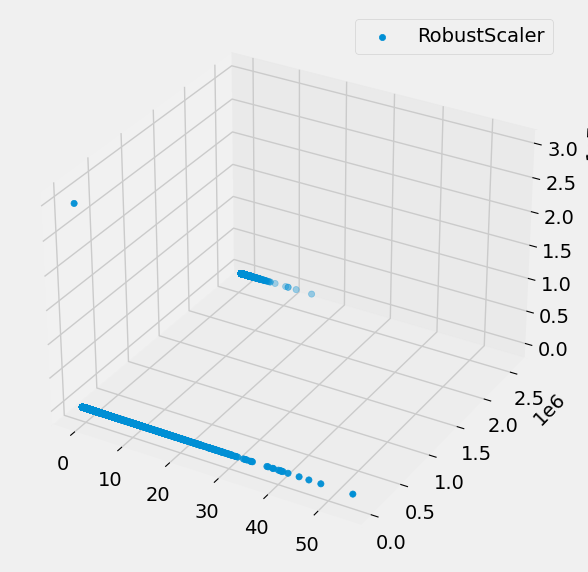

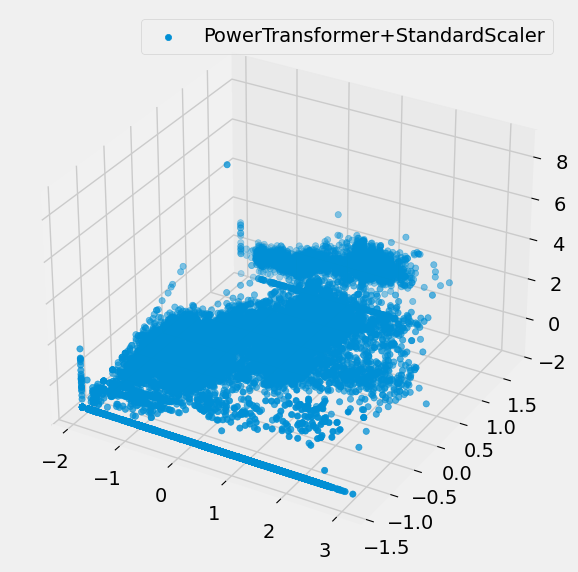

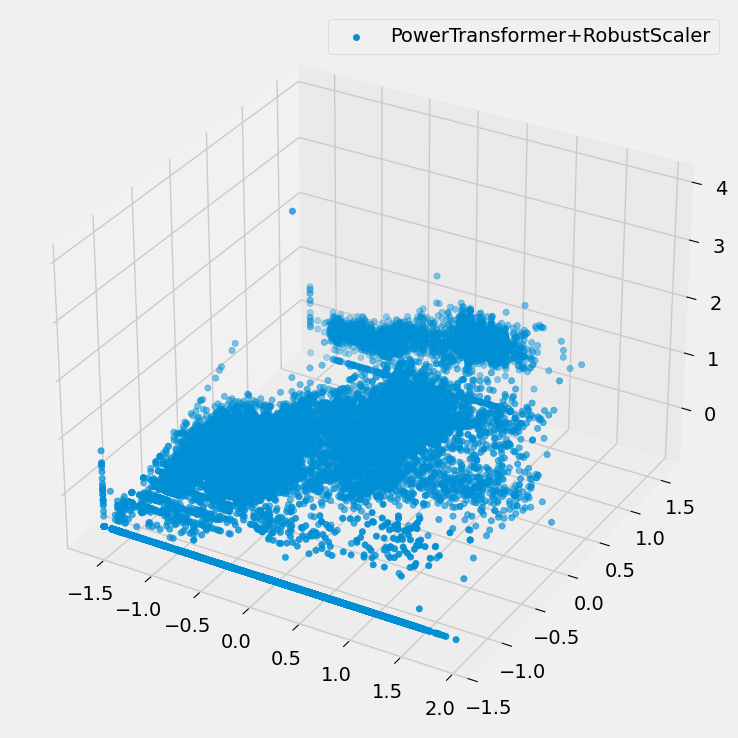

In [27]:
X=df.drop('class',axis=1)
X=X.fillna(0)

# Let's consider 4 scalers
scaler1=StandardScaler()
scaler2=RobustScaler()
scaler3=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',StandardScaler())])
scaler4=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler())])

fig=plt.figure(figsize=(20,15))
ax1=fig.add_subplot(221,projection='3d',)
X_transformed=scaler1.fit_transform(X)
ax1.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],label='StandardScaler')
ax1.legend()

fig=plt.figure(figsize=(20,15))
ax2=fig.add_subplot(222,projection='3d')
X_transformed=scaler2.fit_transform(X)
ax2.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],label='RobustScaler')
ax2.legend()

fig=plt.figure(figsize=(20,15))
ax3=fig.add_subplot(223,projection='3d')
X_transformed=scaler3.fit_transform(X)
ax3.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],label='PowerTransformer+StandardScaler')
ax3.legend()

fig=plt.figure(figsize=(20,15))
ax4=fig.add_subplot(224,projection='3d')
X_transformed=scaler4.fit_transform(X)
ax4.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],label='PowerTransformer+RobustScaler')
ax4.legend()

plt.tight_layout()

**Going forward for cluster analysis, for preprocessing we will use PowerTransformer followed by a scaler rather than only using a scaler. PowerTransformer addresses skewness by transforming the data to be more Gaussian-like, which is particularly important given your heavily right-skewed data. It also helps in making the variance more stable across the dataset. Using a power transformation followed by scaling will ensure that the distances calculated between data points are meaningful and not skewed by outliers or heavily skewed data.
This will lead to better-defined clusters and more accurate clustering results. Reducing skewness and outlier influence will improve the performance of algorithms sensitive to feature scaling. For tree-based models (e.g., decision trees, random forests), scaling is generally less critical, but transforming skewed data can still improve the model's ability to learn from the data effectively. Exactly which PowerTransformer to use and after powertransformer whether to use StandardScaler or RobustScaler can be experimented with.**

## Missing Data Imputation:-
**Since we don't know for sure anything about data, we cannot interpret the missing values and find reasons for missing values. We will consider all types of imputers which seem valid for our data and experiment with all of them. Let's consider 5 types of imputer:- KNN Imputer, Simple Imputer with streategy median, Simple Imputer with stretegy mean, Iterative Imputer.**

In [28]:
X_df=df.drop('class',axis=1)
X_new_df=new_df.drop('class',axis=1)

In [29]:
# Imputers we will be experimenting with 
imputer1_df=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('KNN Imputer',KNNImputer())])
imputer2_df=Pipeline([('Transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('Simple Imputer',SimpleImputer(strategy='median'))])
imputer3_df=Pipeline([('Transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('Simple Imputer',SimpleImputer(strategy='constant',fill_value=0))])
imputer4_df=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('Iterative Imputer',IterativeImputer())])


# PCA:-
**We will use PCA to visualize data in 3d space and look if the classes are seprable. Next we will decide the number of principal components which explain more than 85% variance in original data. We will analyze the factor loadings and try to find most influensial features of the dataset and also find most correlated features.**

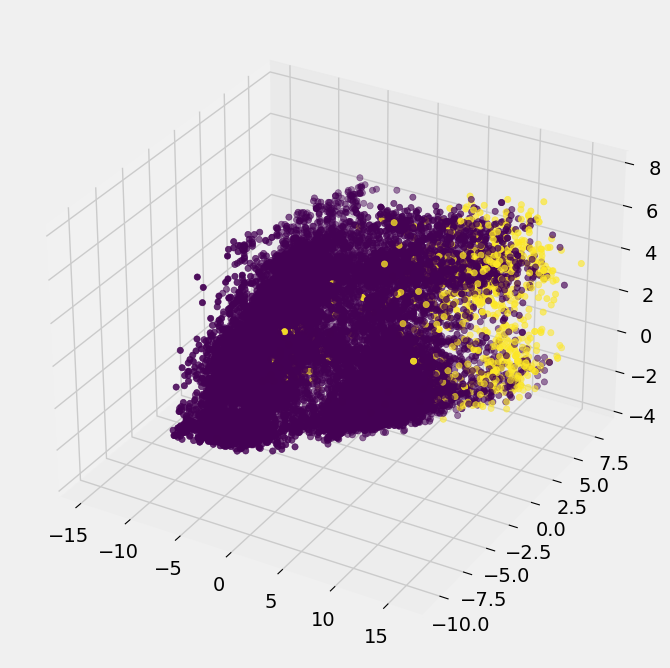

In [30]:
# Visualizing data in 3d space
pca=PCA(n_components=3)
imputer1_df=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('KNN Imputer',KNNImputer())])
X_pca=pca.fit_transform(imputer1_df.fit_transform(X_df))
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=df['class'].apply(lambda x: 1 if x=='pos' else 0))

**The classes are not well-separated in the 3D space created by PCA. This indicates that PCA, which is a linear dimensionality reduction technique, is not able to find a projection where the classes are easily distinguishable. This suggests that the separation between the classes is not well captured by the variance in the data.
PCA preserves the linear structure of the data. It captures the directions of maximum variance without introducing non-linear transformations. This means that any non-linear relationships present in the original data will not be explicitly captured by PCA. We can use TSNE to find non-linear relationships in our data.**

**We can still analyze the factor loadings and try to find out the most influensial variables and highly correlated variables.**

In [31]:
pca=PCA()
imputer1_df=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('KNN Imputer',KNNImputer())])
X_pca=pca.fit_transform(imputer1_df.fit_transform(X_df))

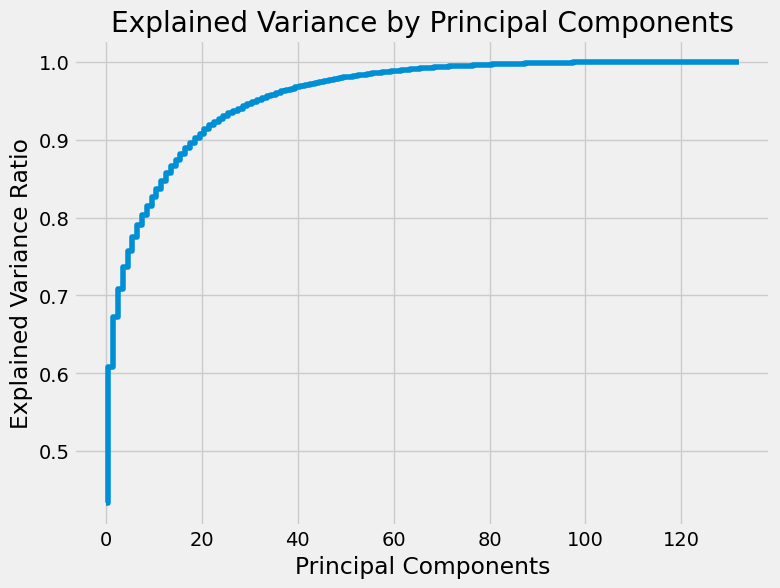

In [32]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.step(range(len(np.cumsum(explained_variance))), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True)


**What does this tell me about the data:-**
1. About 20 principal components capture more than 90% variance of the original data indicating, that we required very few directions to reprsent data in higher dimenssional space. 
2. It also suggests that there are latent factors which that govern the observed data./
3. The original data that we have contains alot of features, but there is alot of redundancy in this data, and most of the information is concentrated in smaller subset of features.
3. This also indicates that alot of features are correlated within the original data.


In [33]:
factor_loadings=np.sqrt(pca.explained_variance_)[:, np.newaxis] * pca.components_
factor_loadings_df=pd.DataFrame(factor_loadings.T[:,:20],index=X_df.columns,columns=[f'PC_{i+1}' for i in range(0,20)])

In [34]:
pc1=factor_loadings_df.iloc[:,0].abs().sort_values(ascending=False)
pc1[pc1>0.5].index

Index(['az_000', 'bl_000', 'bk_000', 'cs_000', 'ba_002', 'bt_000', 'ba_001',
       'aa_000', 'ec_00', 'cs_004', 'cc_000', 'az_005', 'cs_003', 'ba_000',
       'ci_000', 'bg_000', 'ah_000', 'bx_000', 'ao_000', 'ee_000', 'cs_001',
       'ee_005', 'cn_004', 'ba_003', 'cs_005', 'an_000', 'by_000', 'bm_000',
       'dd_000', 'ed_000', 'bu_000', 'cq_000', 'bv_000', 'bb_000', 'az_001',
       'ay_007', 'ee_001', 'cu_000', 'ee_002', 'ag_005', 'ee_004', 'az_002',
       'be_000', 'ee_003', 'bj_000', 'ck_000', 'cn_007', 'bh_000', 'dn_000',
       'aq_000', 'ap_000', 'bi_000', 'de_000', 'cs_002', 'cg_000', 'ds_000',
       'ba_004', 'cn_003', 'dc_000', 'dt_000', 'ee_006', 'cv_000', 'ba_005',
       'cx_000', 'cs_007', 'ct_000', 'cn_005', 'ag_006', 'cs_006', 'ba_006',
       'az_003', 'cn_006', 'ad_000'],
      dtype='object')

In [35]:
pc2=factor_loadings_df.iloc[:,1].abs().sort_values(ascending=False)
pc2[pc2>0.50]

bk_000    2.162948
bl_000    2.104414
bm_000    1.605582
Name: PC_2, dtype: float64

In [36]:
pc3=factor_loadings_df.iloc[:,2].abs().sort_values(ascending=False)
pc3[pc3>0.50]

cn_001    0.696070
ag_003    0.694568
dr_000    0.673852
dq_000    0.671390
cj_000    0.539128
di_000    0.501739
Name: PC_3, dtype: float64

In [37]:
pc4=factor_loadings_df.iloc[:,3].abs().sort_values(ascending=False)
pc4[pc4>0.50]

ac_000    0.698456
Name: PC_4, dtype: float64

In [38]:
pc5=factor_loadings_df.iloc[:,4].abs().sort_values(ascending=False)
pc5[pc5>0.50]

di_000    0.703651
cj_000    0.682178
dh_000    0.671611
Name: PC_5, dtype: float64

**Observations:-**
1. The first principal component captures a substantial 60% of the variance in your data, indicating it plays a pivotal role in summarizing the overall variability. This component underscores the presence of redundancy among variables, with 73 variables exhibiting high loadings (absolute value > 0.5). These variables collectively represent a cohesive underlying factor or pattern that is highly correlated, suggesting overlap in the information they provide.

2. Moreover, certain variables such as "bk_000" and "bl_000" demonstrate multidimensional influence by having high loadings not only on the first principal component but also on subsequent components. This suggests that these variables are pivotal across different dimensions or perspectives within your dataset, highlighting their versatile impact on capturing variability.

3. Conversely, the third principal component is primarily influenced by the variable "ac_000," indicating its singular importance in capturing a distinct direction or factor in your data. This component likely represents a specific aspect that is not well-explained by variables influencing the first two components.

In [39]:
imp_features=set()
for j in range(0,factor_loadings_df.shape[1]):
    component=factor_loadings_df.iloc[:,j]
    imp_features.update(component[np.abs(component)>0.5].index.to_list())
print(imp_features)

{'ee_002', 'cn_007', 'cq_000', 'ay_007', 'by_000', 'bu_000', 'cn_001', 'aa_000', 'cx_000', 'ck_000', 'ds_000', 'ch_000', 'cc_000', 'ba_006', 'bx_000', 'az_002', 'cs_004', 'ap_000', 'cs_007', 'cn_004', 'aq_000', 'dt_000', 'cn_005', 'cv_000', 'bv_000', 'dc_000', 'ee_005', 'bb_000', 'dq_000', 'ba_002', 'cy_000', 'bl_000', 'ai_000', 'aj_000', 'dd_000', 'at_000', 'ag_003', 'bm_000', 'da_000', 'ah_000', 'ao_000', 'cs_005', 'az_001', 'cn_003', 'bt_000', 'ad_000', 'az_000', 'bg_000', 'ag_006', 'bh_000', 'de_000', 'ee_000', 'cs_000', 'ba_003', 'di_000', 'cs_001', 'ag_005', 'ee_004', 'ee_006', 'dr_000', 'cs_003', 'cs_002', 'cj_000', 'ee_001', 'ac_000', 'ed_000', 'bj_000', 'dn_000', 'ct_000', 'az_005', 'an_000', 'az_003', 'ee_003', 'be_000', 'ec_00', 'ba_004', 'cs_006', 'ci_000', 'cu_000', 'dh_000', 'ba_005', 'bk_000', 'ba_000', 'ba_001', 'cn_006', 'bi_000', 'cg_000'}


## Cluster Analysis:-
**Since our data has intrinsic dimensions, doing clustering in the reduced dimension space can actually improve the clustering results, and lead to well seperated clusters if they do exist.**

In [40]:
# Preprocess the data
imputer1_df=Pipeline([('transform',PowerTransformer(method='yeo-johnson')),('Scaling',RobustScaler()),('KNN Imputer',KNNImputer())])
X_transformed=imputer1_df.fit_transform(X_df)

In [41]:
# Apply PCA
pca=PCA(n_components=20)
X_pca=pca.fit_transform(X_transformed)

Text(0.5, 1.0, 'Silhouette Method for Optimal k')

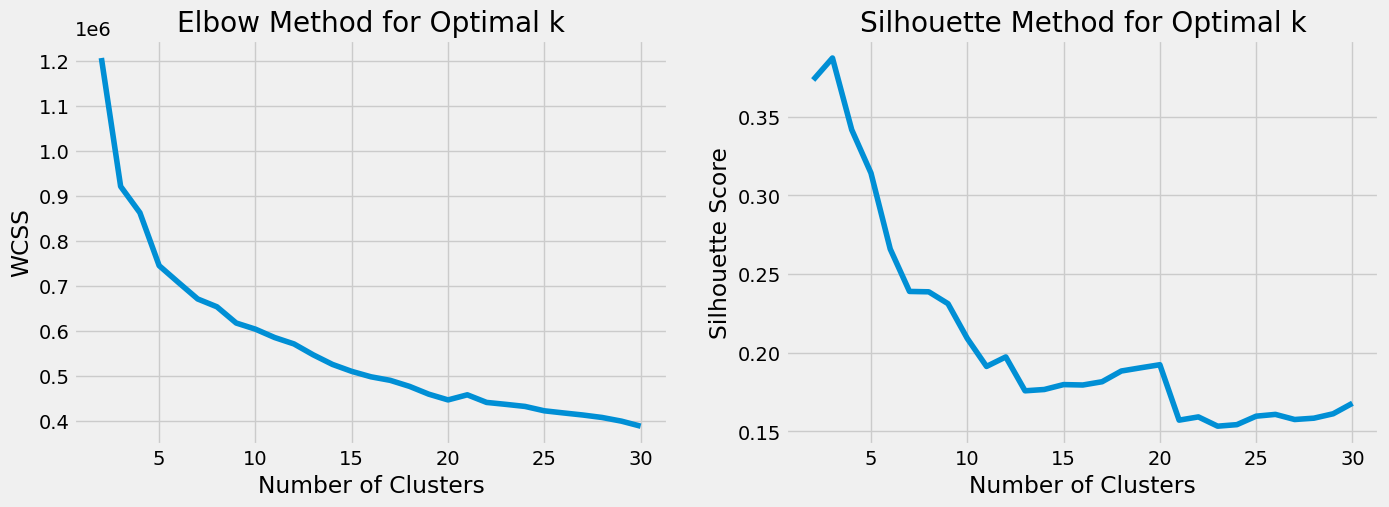

In [42]:
# Apply Kmeans clustering
wcss = []
silhouette_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_pca)
    predicted=kmeans.predict(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS
    silhouette_scores.append(metrics.silhouette_score(X_pca, predicted))

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(range(2, 31), wcss)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WCSS')
ax[0].set_title('Elbow Method for Optimal k')

ax[1].plot(range(2, 31), silhouette_scores)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Method for Optimal k')

**There are no natural clusters in our data.**

# Feature Engineering:-

In [ ]:
# Create new features:-
def engineer_features(df):
    df['ag_00mean']=df[[col for col in df.columns if col[:2]=='ag']].mean(axis=1)
    df['ag_00sum']=df[[col for col in df.columns if col[:2]=='ag']].sum(axis=1)

    df['ay_00mean']=df[[col for col in df.columns if col[:2]=='ay']].mean(axis=1)
    df['ay_00sum']=df[[col for col in df.columns if col[:2]=='ay']].sum(axis=1)

    df['az_00mean']=df[[col for col in df.columns if col[:2]=='az']].mean(axis=1)
    df['az_00sum']=df[[col for col in df.columns if col[:2]=='az']].sum(axis=1)

    df['ba_00mean']=df[[col for col in df.columns if col[:2]=='ba']].mean(axis=1)
    df['ba_00sum']=df[[col for col in df.columns if col[:2]=='ba']].sum(axis=1)

    df['cn_00mean']=df[[col for col in df.columns if col[:2]=='cn']].mean(axis=1)
    df['cn_00sum']=df[[col for col in df.columns if col[:2]=='cn']].sum(axis=1)

    df['cs_00mean']=df[[col for col in df.columns if col[:2]=='cs']].mean(axis=1)
    df['cs_00sum']=df[[col for col in df.columns if col[:2]=='cs']].sum(axis=1)

    df['ee_00mean']=df[[col for col in df.columns if col[:2]=='ee']].mean(axis=1)
    df['ee_00sum']=df[[col for col in df.columns if col[:2]=='ee']].sum(axis=1)

    df['a_mean']=df[[col for col in df.columns if col[:1]=='a']].mean(axis=1)
    df['a_sum']=df[[col for col in df.columns if col[:1]=='a']].sum(axis=1)

    df['b_mean']=df[[col for col in df.columns if col[:1]=='b']].mean(axis=1)
    df['b_sum']=df[[col for col in df.columns if col[:1]=='b']].sum(axis=1)

    df['c_mean']=df[[col for col in df.columns if col[:1]=='c' and col!='class']].mean(axis=1)
    df['c_sum']=df[[col for col in df.columns if col[:1]=='c' and col!='class']].sum(axis=1)

    df['d_mean']=df[[col for col in df.columns if col[:1]=='d']].mean(axis=1)
    df['d_sum']=df[[col for col in df.columns if col[:1]=='d']].sum(axis=1)

    df['e_mean']=df[[col for col in df.columns if col[:1]=='e']].mean(axis=1)
    df['e_sum']=df[[col for col in df.columns if col[:1]=='e']].sum(axis=1)



# Model Building

In [66]:
# Prepare the data for model building
X,y=df.drop('class',axis=1),df['class']
y=y.replace({'pos':1,'neg':0})

In [70]:
def perform_cross_validation(model, X, y):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    scoring = ['f1']
    results = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True)
    
    train_scores = results['train_f1']
    test_scores = results['test_f1']
    
    print("Training F1 Scores:", train_scores)
    print("Mean Training F1 Score:", np.mean(train_scores))
    print("Validation F1 Scores:", test_scores)
    print("Mean Validation F1 Score:", np.mean(test_scores))
    
    return train_scores, test_scores

## 1. Logisitic Regression
We are going to try different variations of preprocessor and also perform hyperparameterization.

In [71]:
# StandardScaler+ Simple Imputer(0)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Scaler',StandardScaler()),('Imputer',SimpleImputer(strategy='constant',fill_value=0))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80067002 0.79330544 0.80858086 0.79222973 0.8034632 ]
Mean Training F1 Score: 0.799649849471941
Validation F1 Scores: [0.74172185 0.77377049 0.75       0.73154362 0.71856287]
Mean Validation F1 Score: 0.743119768904097


In [72]:
# StandardScaler+ Simple Imputer(mean)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Scaler',StandardScaler()),('Imputer',SimpleImputer(strategy='mean',fill_value=0))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80067002 0.79330544 0.80858086 0.79222973 0.80138768]
Mean Training F1 Score: 0.7992347456396646
Validation F1 Scores: [0.74172185 0.77377049 0.75       0.73154362 0.72072072]
Mean Validation F1 Score: 0.7435513381979417


In [73]:
# StandardScaler+ Simple Imputer(median)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Scaler',StandardScaler()),('Imputer',SimpleImputer(strategy='median',fill_value=0))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80467446 0.79362416 0.80889621 0.79261125 0.80689655]
Mean Training F1 Score: 0.8013405264299394
Validation F1 Scores: [0.72847682 0.77377049 0.75471698 0.72972973 0.72072072]
Mean Validation F1 Score: 0.7414829489155714


In [74]:
# Power Transformer +StandardScaler+ Simple Imputer(0)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Transformer',PowerTransformer('yeo-johnson')),('Scaler',StandardScaler()),('Imputer',SimpleImputer(strategy='constant',fill_value=0))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80360065 0.81050041 0.80415667 0.80562448 0.8075278 ]
Mean Training F1 Score: 0.8062820048161289
Validation F1 Scores: [0.75958188 0.7628866  0.78545455 0.73103448 0.77575758]
Mean Validation F1 Score: 0.7629430166883975


In [75]:
# Power Transformer +StandardScaler+ Simple Imputer(mean)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Transformer',PowerTransformer('yeo-johnson')),('Scaler',StandardScaler()),('Imputer',SimpleImputer(strategy='mean',fill_value=0))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80360065 0.81050041 0.80415667 0.80562448 0.80887372]
Mean Training F1 Score: 0.806551188535477
Validation F1 Scores: [0.75958188 0.7628866  0.78545455 0.73103448 0.76969697]
Mean Validation F1 Score: 0.7617308954762763


In [76]:
# Power Transformer +StandardScaler+ Simple Imputer(medain)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Transformer',PowerTransformer('yeo-johnson')),('Scaler',StandardScaler()),('Imputer',SimpleImputer(strategy='median',fill_value=0))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80363036 0.80784955 0.80193237 0.80823045 0.80377035]
Mean Training F1 Score: 0.8050826168950665
Validation F1 Scores: [0.76816609 0.75254237 0.78985507 0.73611111 0.76876877]
Mean Validation F1 Score: 0.7630886830380803


In [77]:
# StandardScaler+ KNN Imputer(0)+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Scaler',StandardScaler()),('Imputer',KNNImputer(n_neighbors=3))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.79054054 0.79564489 0.79802956 0.78504673 0.78596491]
Mean Training F1 Score: 0.791045325913146
Validation F1 Scores: [0.71917808 0.76510067 0.72862454 0.74342105 0.73394495]
Mean Validation F1 Score: 0.7380538590817449


In [78]:
# Power Transformer +StandardScaler+ KNN Imputer+Default Model+ No oversampling
preprocessing_pipeline = Pipeline([('Transformer',PowerTransformer('yeo-johnson')),('Scaler',StandardScaler()),('Imputer',KNNImputer(n_neighbors=3))])
model=Pipeline([('Preprocessor',preprocessing_pipeline),('Logisitic Regression',LogisticRegression())])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.8        0.79146141 0.80096308 0.80264244 0.79796265]
Mean Training F1 Score: 0.7986059173661687
Validation F1 Scores: [0.74740484 0.79863481 0.78545455 0.74226804 0.77203647]
Mean Validation F1 Score: 0.7691597434866279


In [79]:
# Try with oversampling
model= ImbPipeline([
    ('Transformer', PowerTransformer('yeo-johnson')),
    ('Scaler', StandardScaler()),
    ('Imputer', KNNImputer(n_neighbors=3)),
    ('SMOTE', SMOTE(random_state=42, sampling_strategy=0.05)),
    ('Classifier', LogisticRegression())
])
cross_val_scores=perform_cross_validation(model,X,y)

Training F1 Scores: [0.80122794 0.80521472 0.80120482 0.80310078 0.81132075]
Mean Training F1 Score: 0.8044138017295307
Validation F1 Scores: [0.75657895 0.7721519  0.79725086 0.76038339 0.78034682]
Mean Validation F1 Score: 0.773342382519969


In [80]:
# The best value of n_neighbors:-
model= ImbPipeline([
    ('Transformer', PowerTransformer('yeo-johnson')),
    ('Scaler', StandardScaler()),
    ('Imputer', KNNImputer()),
    ('SMOTE', SMOTE(random_state=42, sampling_strategy=0.05)),
    ('Classifier', LogisticRegression())
])
param_grid={'Imputer_n_neighbors':[3,5,10]}
grid=GridSearchCV(model,param_grid,scoring='f1')
grid.fit(X,y)
best_params=grid.best_params_
best_score=grid.best_score_
print(f"Best params: {best_params} Best Score: {best_score}")

ValueError: Invalid parameter 'model' for estimator Pipeline(steps=[('Transformer', PowerTransformer()),
                ('Scaler', StandardScaler()), ('Imputer', KNNImputer()),
                ('SMOTE', SMOTE(random_state=42, sampling_strategy=0.05)),
                ('Classifier', LogisticRegression())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [47]:
# Load all ready preprocessed data
train,test=load_numpy_array('D://DataScience//Projects//SensorProject//End-To-End-ML-Project//Artifact//DataTransformation//train.npy'),load_numpy_array('D://DataScience//Projects//SensorProject//End-To-End-ML-Project//Artifact//DataTransformation//test.npy')
X_train,y_train=train[:,:-1],train[:,-1]
X_test,y_test=test[:,:-1],test[:,-1]

# Define model
model=LogisticRegression()

# Perform Hyperparameter Optimization with train-test split
param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Define Grid
grid=GridSearchCV(model,param_grid,scoring='f1')
# Fit to X,y
grid.fit(X_train,y_train)
best_params=grid.best_params_
best_score=grid.best_score_
print(f"Best params: {best_params} Best Score: {best_score}")

logreg=LogisticRegression(**best_params)
logreg.fit(X_train,y_train)
train_predictions=logreg.predict(X_train)
test_predictions=logreg.predict(X_test)
print(metrics.f1_score(y_train,train_predictions))
print(metrics.f1_score(y_test,test_predictions))

Best params: {'solver': 'lbfgs'} Best Score: 0.8016915377091486
0.819718309859155
0.806282722513089


## 2. SVM

In [49]:
# Load all ready preprocessed data
train,test=load_numpy_array('D://DataScience//Projects//SensorProject//End-To-End-ML-Project//Artifact//DataTransformation//train.npy'),load_numpy_array('D://DataScience//Projects//SensorProject//End-To-End-ML-Project//Artifact//DataTransformation//test.npy')
X_train,y_train=train[:,:-1],train[:,-1]
X_test,y_test=test[:,:-1],test[:,-1]

# Define model
model=SVC()

# Perform Hyperparameter Optimization with train-test split
param_grid={
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
  }

# Define Grid
grid=GridSearchCV(model,param_grid,scoring='f1')
# Fit to X,y
grid.fit(X_train,y_train)
best_params=grid.best_params_
best_score=grid.best_score_
print(f"Best params: {best_params} Best Score: {best_score}")

svc=SVC(**best_params)
svc.fit(X_train,y_train)
train_predictions=svc.predict(X_train)
test_predictions=svc.predict(X_test)
print(metrics.f1_score(y_train,train_predictions))
print(metrics.f1_score(y_test,test_predictions))

Best params: {'gamma': 'scale', 'kernel': 'poly'} Best Score: 0.8225607869713958
0.9071192833569072
0.7968337730870713


In [56]:
train,test=load_numpy_array('D://DataScience//Projects//SensorProject//End-To-End-ML-Project//Artifact//DataTransformation//train.npy'),load_numpy_array('D://DataScience//Projects//SensorProject//End-To-End-ML-Project//Artifact//DataTransformation//test.npy')
X_train,y_train=train[:,:-1],train[:,-1]
X_test,y_test=test[:,:-1],test[:,-1]

In [61]:
x=RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=2)
x.fit(X_train,y_train)
train_predictions=x.predict(X_train)
test_predictions=x.predict(X_test)
print(metrics.f1_score(y_train,train_predictions))
print(metrics.f1_score(y_test,test_predictions))

0.9545875810936052
0.8244274809160306
